In [137]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
# Append source directory to path
sys.path.append("../../src/")
import hipopy.hipopy
import ROOT
from particle import Particle
import matplotlib.pyplot as plt
# Import custom modules
from model_functions import clip_out_beta
from ECALDataReader import ECALDataReader
from TrainData import load_unzip_data
from loss_functions import CustomLoss, AttractiveLossMetric, RepulsiveLossMetric, CowardLossMetric, NoiseLossMetric
from ModelEcalPlotter import ModelEcalPlotter
from Evaluator import Evaluator
from global_params import *
plt.style.use('science')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import math
from matplotlib.gridspec import GridSpec

This analysis notebook lets us study the *before* and *after* of the object condensation...

In [138]:
# Obtain relevant files
def get_files(project_name, file_basename):
    dst_dir = f'../../projects/{project_name}/dst/'
    predict_dir = f'../../projects/{project_name}/predict/'
    training_dir = f'../../projects/{project_name}/training/'

    coatjava_hipofile = f'{dst_dir}/{file_basename}.hipo'
    objectcondensation_hipofile = f'{predict_dir}/{file_basename}_ML.hipo'
    objectcondensation_h5file = f'{training_dir}/{file_basename}.h5'
    return coatjava_hipofile, objectcondensation_hipofile, objectcondensation_h5file

# Extract model training data
def get_model_inputs(h5file):
    X, y, misc = load_unzip_data(h5file)
    return X, y, misc

# Get model evaluator
def get_evaluator(h5file="", model_load_path="", tB=0.8, tD=0.2, offset=0):
    X, y, misc = get_model_inputs(h5file)
    print(X)
    # Load the model
    model = tf.keras.models.load_model(model_load_path, custom_objects={
        'CustomLoss': CustomLoss, 
        'AttractiveLossMetric': AttractiveLossMetric,
        'RepulsiveLossMetric': RepulsiveLossMetric,
        'CowardLossMetric': CowardLossMetric,
        'NoiseLossMetric': NoiseLossMetric,
        'clip_out_beta': clip_out_beta
    })
    # The event number in the hipofiles can be offset
    ev_numbers = misc[:,:,3]
    ev_numbers = ev_numbers - ev_numbers[0][0]
    unique_ev_numbers = np.unique(ev_numbers)
    true_offset = list(unique_ev_numbers).index(offset)
    ecal_x = X[true_offset:true_offset+1]
    ecal_y = y[true_offset:true_offset+1]
    ecal_misc = misc[true_offset:true_offset+1]
    evaluator = Evaluator(X=ecal_x,y=ecal_y,misc=ecal_misc)
    evaluator.load_model(model)
    evaluator.predict()
    evaluator.cluster(tB, tD)
    return evaluator

# Extract hipo bank information for a specific event
def retreive_hipo_bank_info(hipofile, event_num):
    file = hipopy.hipopy.open(hipofile, mode='r')
    csvfile = hipofile.replace(".hipo",".csv").replace("_ML","").replace("dst","training").replace("predict","training")
    csv = pd.read_csv(csvfile)
    # Group by 'event' column and filter groups with only one row
    single_row_events = csv.groupby('event').filter(lambda x: len(x) == 1).event.unique()
    for i,event in enumerate(file):
        if i<event_num:
            continue
        if i in single_row_events:
            print(f"Skipping Event #{i} since it left no ECAL::hits")
            return False, False
        RECpx = np.array(file.getFloats("REC::Particle","px"))
        RECpy = np.array(file.getFloats("REC::Particle","py"))
        RECpz = np.array(file.getFloats("REC::Particle","pz"))
        RECpid = np.array(file.getInts("REC::Particle","pid"))
        ecal_x = np.array(file.getFloats("REC::Calorimeter","x"))
        ecal_y = np.array(file.getFloats("REC::Calorimeter","y"))
        ecal_sector = np.array(file.getBytes("REC::Calorimeter","sector"))
        ecal_layer  = np.array(file.getBytes("REC::Calorimeter","layer"))
        ecal_pindex = np.array(file.getShorts("REC::Calorimeter","pindex"))
        RECm = np.array([Particle.from_pdgid(p).mass if (p!=0 and p!=45) else 0 for p in RECpid])/1000
        RECall=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m] in zip(RECpx,RECpy,RECpz,RECm)]
        RECgammas=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2)) for [px,py,pz,pid] in zip(RECpx,RECpy,RECpz,RECpid) if pid==22]
        RECneutralhadrons=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(RECpx,RECpy,RECpz,RECm,RECpid) if (pid==2112)]
        RECchargedhadrons=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(RECpx,RECpy,RECpz,RECm,RECpid) if (pid==211 or pid==-211 or pid==321 or pid==-321 or pid==2212)]
        RECe=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(RECpx,RECpy,RECpz,RECm,RECpid) if pid==11]
        RECpositrons=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(RECpx,RECpy,RECpz,RECm,RECpid) if pid==-11]
        MCpx = np.array(file.getFloats("MC::Particle","px"))
        MCpy = np.array(file.getFloats("MC::Particle","py"))
        MCpz = np.array(file.getFloats("MC::Particle","pz"))
        MCpid = np.array(file.getInts("MC::Particle","pid"))
        MCm = np.array([Particle.from_pdgid(p).mass if (p!=0 and p!=91 and p!=92) else 0 for p in MCpid]).astype(float)/1000
        MCGenPindex = np.array(file.getShorts("MC::GenMatch","pindex"))
        idx_where_gen_has_rec = MCGenPindex!=-1
        print([p.Px() for p in RECpositrons],"***")
        MCall=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m] in zip(MCpx,MCpy,MCpz,MCm)]
        MCgammas=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2)) for [px,py,pz,pid] in zip(MCpx,MCpy,MCpz,MCpid) if pid==22]
        
        MCneutralhadrons=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(MCpx,MCpy,MCpz,MCm,MCpid) if (pid==2112)]
        MCchargedhadrons=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(MCpx,MCpy,MCpz,MCm,MCpid) if (pid==211 or pid==-211 or pid==321 or pid==-321 or pid==2212)]
        MCe=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(MCpx,MCpy,MCpz,MCm,MCpid) if pid==11]
        MCpositrons=[ROOT.TLorentzVector(px,py,pz,np.sqrt(px**2+py**2+pz**2+m**2)) for [px,py,pz,m,pid] in zip(MCpx,MCpy,MCpz,MCm,MCpid) if pid==-11]
        break

    bank_info = {
        "RECall": RECall,
        "RECe": RECe,
        "RECpositrons": RECpositrons,
        "RECgammas": RECgammas,
        "RECneutralhadrons": RECneutralhadrons,
        "RECchargedhadrons": RECchargedhadrons,
        "MCe": MCe,
        "MCgammas": MCgammas,
        "MCneutralhadrons": MCneutralhadrons,
        "MCchargedhadrons": MCchargedhadrons,
        "MCpositrons": MCpositrons,
        "MChasREC": idx_where_gen_has_rec,
        "MCall": MCall,
        "ecal_pindex": ecal_pindex
    }

    return bank_info, filter_bank_info(bank_info)

# Filter out TLorentzVector elements with theta < 5 or theta > 35 degrees
def filter_bank_info(bank_info):
    def filter_vectors(vectors):
        # return vectors
        return [vec if 5 <= math.degrees(vec.Theta()) <= 35 else -1 for vec in vectors]

    # Apply the filter to each list of TLorentzVectors in bank_info
    modified_bank_info = {
        "RECall": bank_info["RECall"],
        "RECe": filter_vectors(bank_info["RECe"]),
        "RECpositrons": filter_vectors(bank_info["RECpositrons"]),
        "RECgammas": filter_vectors(bank_info["RECgammas"]),
        "RECneutralhadrons": filter_vectors(bank_info["RECneutralhadrons"]),
        "RECchargedhadrons": filter_vectors(bank_info["RECchargedhadrons"]),
        "MCall": bank_info["MCall"],
        "MCe": filter_vectors(bank_info["MCe"]),
        "MCgammas": filter_vectors(bank_info["MCgammas"]),
        "MCneutralhadrons": filter_vectors(bank_info["MCneutralhadrons"]),
        "MCchargedhadrons": filter_vectors(bank_info["MCchargedhadrons"]),
        "MCpositrons": filter_vectors(bank_info["MCpositrons"]),
        "MChasREC": bank_info["MChasREC"],
        "ecal_pindex": bank_info["ecal_pindex"]
    }

    return modified_bank_info

def check_particle_counts(bank_info, criteria):
    """
    Check if the counts of particles in bank_info match the given criteria.

    Args:
    - bank_info (dict): Dictionary containing lists of TLorentzVectors for different particle types.
    - criteria (dict): Dictionary with keys as particle types (e.g., "RECe", "RECgammas")
                       and values as [min, max] list specifying the required range of particles.

    Returns:
    - bool: True if all criteria are met, False otherwise.
    """
    for particle_type, (min_count, max_count) in criteria.items():
        if particle_type in bank_info:
            particles = [part for part in bank_info[particle_type] if type(part)==ROOT.TLorentzVector]
            particle_count = len(particles)
            # Check if the particle count is within the specified min-max range
            if not (min_count <= particle_count <= max_count):
                return False
        else:
            # If the particle_type doesn't exist in bank_info, return False if the min count is > 0
            if min_count > 0:
                return False

    # If no criteria or all criteria are met, return True
    return True


def hunt_event(coatjava_hipofile, objectcondensation_hipofile, criteria, skip=0, search="coatjava"):
    assert(search in ["coatjava","objectcondensation"])
    assert(type(criteria)==dict)

    if search=="coatjava":
        hipofile = coatjava_hipofile
    else:
        hipofile = objectcondensation_hipofile
        
    for event_num in range(1000):
        if event_num<skip:
            continue
        bank_info, filtered_bank_info = retreive_hipo_bank_info(hipofile = hipofile,
                                                                event_num = event_num)
        if bank_info == False:
            continue
            
        if check_particle_counts(filtered_bank_info,criteria):
            return event_num

    print("ERROR: No valid event found that meets the criteria")
    return -1

In [139]:
# Plot the (Theta,Phi) graph
def plot_theta_phi_points(ax,bank_info):
    RECe = bank_info["RECe"]
    RECpositrons = bank_info["RECpositrons"]
    RECgammas = bank_info["RECgammas"]
    RECneutralhadrons = bank_info["RECneutralhadrons"]
    RECchargedhadrons = bank_info["RECchargedhadrons"]
    MCe = bank_info["MCe"]
    MCpositrons = bank_info["MCpositrons"]
    MCgammas = bank_info["MCgammas"]
    MCneutralhadrons = bank_info["MCneutralhadrons"]
    MCchargedhadrons = bank_info["MCchargedhadrons"]
    idx_where_gen_has_rec = bank_info["MChasREC"]
    MCall = bank_info["MCall"]
    def mec(p):
        for i,tp in enumerate(MCall):
            if p==tp:
                if idx_where_gen_has_rec[i]==True:
                    return "k"
                else:
                    return "None" 
        return "None"

        
    # Placeholder for each label to ensure the legend entries appear even if no points are plotted
    legend_ms = 10
    ax.plot([-999], [-999], "^", color="darkred", alpha=0.8, label="$e_{MC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "^", color="darkmagenta", alpha=0.8, label="$e^{+}_{MC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "^", color="cornflowerblue", alpha=0.8, label="$\gamma_{MC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "^", color="black", alpha=0.8, label="$h^{0}_{MC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "^", color="darkgreen", alpha=0.8, label="$h^{\pm}_{MC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "v", color="red", alpha=0.8, label="$e_{REC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "v", color="magenta", alpha=0.8, label="$e^{+}_{REC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "v", color="aqua", alpha=0.8, label="$\gamma_{REC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "v", color="grey", alpha=0.8, label="$h^{0}_{REC}$", markeredgecolor="k",markersize=legend_ms)
    ax.plot([-999], [-999], "v", color="limegreen", alpha=0.8, label="$h^{\pm}_{REC}$", markeredgecolor="k",markersize=legend_ms)


    markermin = 8
    
    for p in MCe:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"^",markersize=p.P()*4+markermin,color="darkred",alpha=0.8,markeredgecolor=mec(p))
    for p in MCpositrons:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"^",markersize=p.P()*4+markermin,color="darkmagenta",alpha=0.8,markeredgecolor=mec(p))
    for p in MCgammas:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"^",markersize=p.P()*4+markermin,color="cornflowerblue",alpha=0.8,markeredgecolor=mec(p))
    for p in MCchargedhadrons:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"^",markersize=p.E()*4+markermin,color="darkgreen",alpha=0.8,markeredgecolor=mec(p))
    for p in MCneutralhadrons:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"^",markersize=p.P()*4+markermin,color="black",alpha=0.8,markeredgecolor=mec(p))

        
    for p in RECe:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"rv",markersize=p.P()*4+markermin,alpha=0.8,markeredgecolor="k")      
    for p in RECpositrons:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"v",color="magenta",markersize=p.P()*4+markermin,alpha=0.8,markeredgecolor="k")       
    for p in RECgammas:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"v",markersize=p.P()*4+markermin,color="aqua",alpha=0.8,markeredgecolor="k")
    for p in RECchargedhadrons:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"v",markersize=p.E()*4+markermin,color="limegreen",alpha=0.8,markeredgecolor="k")
    for p in RECneutralhadrons:
        if type(p)!=ROOT.TLorentzVector:
            continue
        ax.plot([p.Theta()*180/np.pi],[p.Phi()*180/np.pi],"v",markersize=p.P()*4+markermin,color="grey",alpha=0.8,markeredgecolor="k")


    legend = ax.legend(loc='best',frameon=True, ncol=2,fontsize=8)
    ax.set_xlim(5,35)
    ax.set_ylim(-180,180)
    ax.set_xlabel("Lab Theta [$\\theta$]",fontsize=14)
    ax.set_ylabel("Lab Phi   [$\phi$]",fontsize=14)
    frame  = legend.get_frame()
    frame.set_edgecolor('black')

In [140]:
def event_plot(project_name="", file_basename="", model_load_path="", criteria={}, skip=0, tB=0.5, tD=0.5, bland=False, search="coatjava"):
    coatjava_hipofile, objectcondensation_hipofile, objectcondensation_h5file = get_files(project_name=project_name,
                                                                                          file_basename=file_basename)

    event_num = hunt_event(coatjava_hipofile, objectcondensation_hipofile, criteria, skip, search=search)
    print("Event Number -->", event_num, "passes desired criteria...")
    if criteria != {}:
        display(criteria)

    coatjavabank_info, filtered_coatjavabank_info = retreive_hipo_bank_info(hipofile=coatjava_hipofile, event_num=event_num)

    objectcondensationbank_info, filtered_objectcondensationbank_info = retreive_hipo_bank_info(hipofile=objectcondensation_hipofile, event_num=event_num)

    print(coatjavabank_info["RECgammas"])
    print(objectcondensationbank_info["RECgammas"])
    
    fig,axs = plt.subplots(2,3,figsize=(15,10),dpi=150)
    ax0=axs[0][0]
    ax1=axs[0][1]
    ax2=axs[0][2]
    ax3=axs[1][0]
    #fig.delaxes(ax3)
    ax4=axs[1][1]
    ax5=axs[1][2]
    evaluator = get_evaluator(objectcondensation_h5file, model_load_path, offset=event_num, tB=tB, tD=tD)
    df = evaluator.get_event_dataframe(0)
    if bland==True:
        df["mc_pid"] = 0
        df["unique_otid"] = 0
    ecal_plotter = ModelEcalPlotter(df, use_clas_calo_scale=True)

    ecal_plotter.plot_mc_peaks(ax0)
    ax0.set_title("Monte Carlo Truth Level",fontsize=18)
    ax0.legend().remove()
    #ax0.legend(frameon=True, ncols=2, bbox_to_anchor=(0.5, -0.15), loc='upper center')
    
    plot_theta_phi_points(ax1, coatjavabank_info)
    ax1.set_title("Coatjava",fontsize=15)


    plot_theta_phi_points(ax2, objectcondensationbank_info)
    ax2.set_title("Object Condensation",fontsize=15)

    ecal_plotter.plot_cluster_latent_space(tD, ax3)
    ax3.set_title("Latent Space",fontsize=18)
    ax3.legend(frameon=True, ncols=2, bbox_to_anchor=(0.5, -0.15), loc='upper center')
    
    # Bottom left plot in the original layout
    ecal_plotter.plot_rec_peaks(ax=ax4)
    ax4.legend(frameon=True, ncols=2, bbox_to_anchor=(0.5, -0.15), loc='upper center')

    # Bottom right plot in the original layout
    ecal_plotter.plot_clustered_ecal_peaks(ax=ax5)

    #plt.subplots_adjust(left=0.15, right=0.85, wspace=0.3)  # Adjust the right margin and space between subplots

    #plt.tight_layout()
    plt.show()

    return event_num

# User-Defined Section

Skipping Event #0 since it left no ECAL::hits
[] ***
[-0.3484661877155304] ***
Event Number --> 2 passes desired criteria...


{'MCneutralhadrons': [0, 10], 'RECneutralhadrons': [1, 10]}

[-0.3484661877155304] ***
[-0.3484661877155304] ***
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.04678667 0.15319264 0.48291597 ... 0.         0.         0.        ]
  [0.02682    0.17138128 0.4811614  ... 0.         0.         0.        ]
  [0.01676    0.17096487 0.48244596 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.13688667 0.15765199 0.48125327 ... 0.  

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 194.69it/s]
/w/hallb-scshelf2102/clas12/users/gmat/clas12/neutneut/analysis/neutron_ml/../../src/ECALClusterAnalyzer.py:111: RuntimeWarning: invalid value encountered in scalar divide
  weighted_avg_x = np.sum(priority_group['centroid_x'] * weights_x) / np.sum(weights_x)
/w/hallb-scshelf2102/clas12/users/gmat/clas12/neutneut/analysis/neutron_ml/../../src/ECALClusterAnalyzer.py:112: RuntimeWarning: invalid value encountered in scalar divide
  weighted_avg_y = np.sum(priority_group['centroid_y'] * weights_y) / np.sum(weights_y)
/w/hallb-scshelf2102/clas12/users/gmat/clas12/neutneut/analysis/neutron_ml/../../src/ECALClusterAnalyzer.py:111: RuntimeWarning: invalid value encountered in scalar divide
  weighted_avg_x = np.sum(priority_group['centroid_x'] * weights_x) / np.sum(weights_x)
/w/hallb-scshelf2102/clas12/users/gmat/clas12/neutneut/analysis/neutron_ml/../../src/ECALClusterAnalyzer.py:112: RuntimeWarning: invalid val

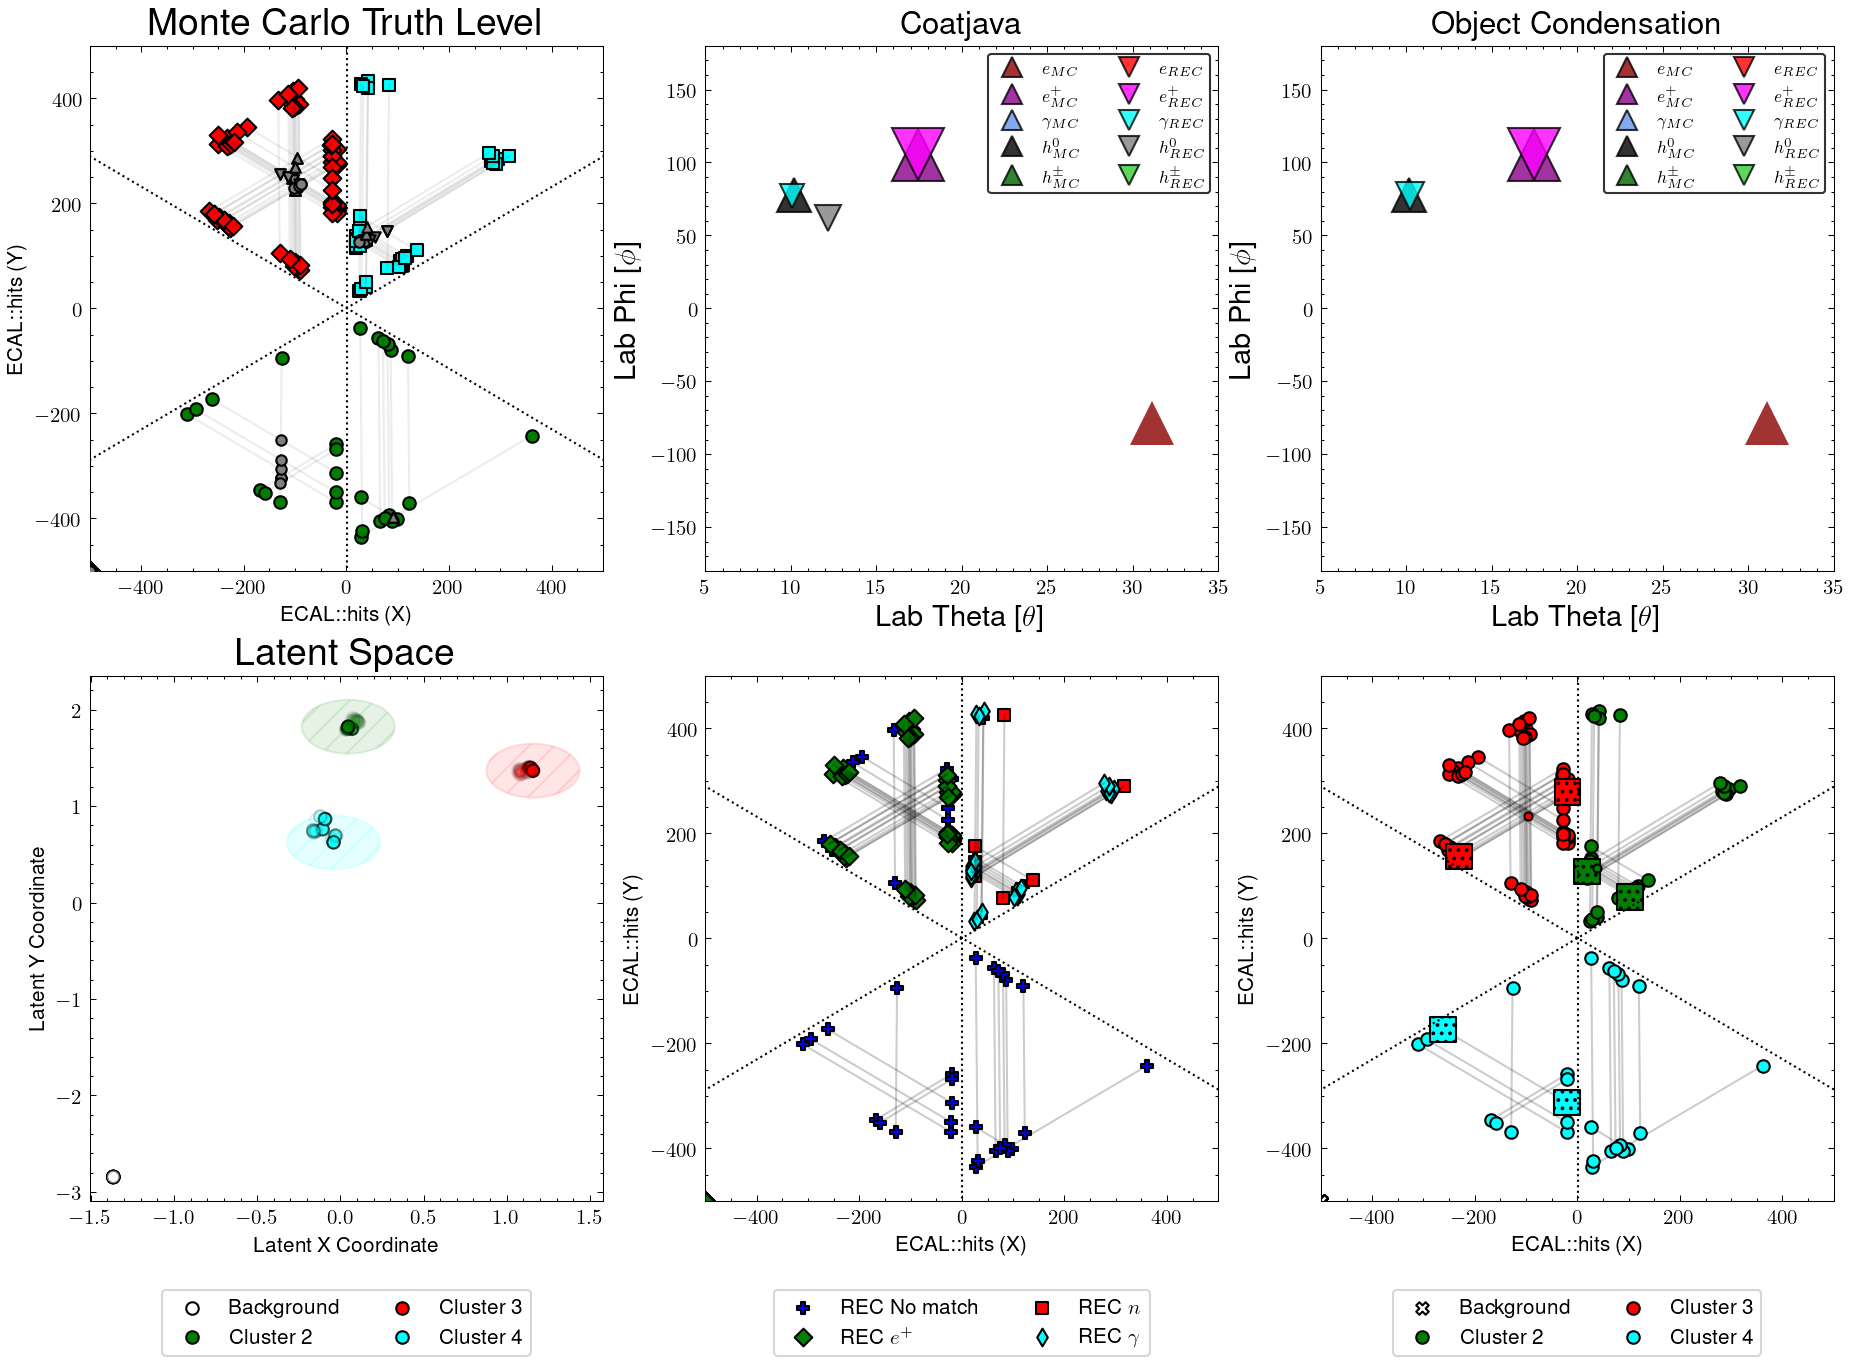

compression type = 0 data length = 25839
compression type = 0 data length = 25839
compression type = 0 data length = 25839
compression type = 0 data length = 25839
compression type = 0 data length = 25839


In [162]:
# project_name    = "converge.10.14.2024.13.20"
# file_basename   = "clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0010"

# project_name    = "neutron_fire.11.01.2024.11.41"
# file_basename   = "___1.5___10.0___0.0___0.01___0.01___0.01___neutron___"


project_name    = "richard.v2.11.05.2024.12.35"
file_basename   = "eD_n2eFPS_132"


model_load_path = "../../projects/converge.10.14.2024.13.20/tensorflow/episode_0002/config_0001/trained_model.keras"

criteria_0 = {}
criteria_1 = {"MCneutralhadrons": [0,10],"RECneutralhadrons": [1,10]}

# 25, 80, 100
evnum=event_plot(project_name    = project_name,
           file_basename         = file_basename,
           model_load_path = model_load_path,
           criteria        = criteria_1,
           skip            = 0,
           tB              = 0.5,
           tD              = 0.28,
           bland           = False,
           search          = 'coatjava')

In [155]:
# Define the file path
import h5py
file_path = '/home/gmat/link_to_clas12/clas12/neutneut/projects/richard.v2.11.05.2024.12.35/training/eD_n2eFPS_132.h5'

# Open the h5 file and load the data for 'X', 'y', and 'misc' groups
with h5py.File(file_path, 'r') as h5_file:
    # Assuming 'X', 'y', and 'misc' are top-level groups/datasets in the file
    X_data = h5_file['X'][:]
    y_data = h5_file['y'][:]
    misc_data = h5_file['misc'][:]
i = 0
X_data[i:i+1], y_data[i:i+1], misc_data[i:i+1]

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
 array([[[-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1., -1.],
         [-1.,

In [80]:

coatjava_hipofile, objectcondensation_hipofile, objectcondensation_h5file = get_files(project_name,suffix)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

NameError: name 'suffix' is not defined

In [161]:
[[8]]*9

[[8], [8], [8], [8], [8], [8], [8], [8], [8]]

In [14]:

def readme(hipofile):
    reader = ECALDataReader(hipofile)
    for i,event in enumerate(reader.file):
        if i!=evnum:
            continue
        rec_parts = reader.get_dict("REC::Particle")
        rec_parts['theta'] = np.degrees(np.arctan2(np.sqrt(rec_parts['px']**2 + rec_parts['py']**2), rec_parts['pz']))
        rec_parts['phi'] = np.degrees(np.arctan2(rec_parts['py'], rec_parts['px']))
        rec_calo  = reader.get_dict("REC::Calorimeter")
        mc_parts = reader.get_dict("MC::Particle")
        mc_parts['theta'] = np.degrees(np.arctan2(np.sqrt(mc_parts['px']**2 + mc_parts['py']**2), mc_parts['pz']))
        mc_parts['phi'] = np.degrees(np.arctan2(mc_parts['py'], mc_parts['px']))
        ecal_hits = reader.get_dict("ECAL::hits+")
        display(rec_parts)
        display(rec_calo)
        display(mc_parts)
        display(ecal_hits)
        break

In [15]:
readme(coatjava_hipofile)

,pid,px,py,pz,vx,vy,vz,vt,charge,beta,chi2pid,status,theta,phi
0,0,-0.160702,0.225045,0.197422,0.014942,0.003243,0.14603,-1.0,-1,0.0,9999.0,4120,54.476222,125.530230
1,22,0.439005,0.327955,1.126797,0.014942,0.003243,0.14603,-1.0,0,0.0,9999.0,2020,25.934344,36.761252
2,22,0.043423,-0.115548,0.363788,0.014942,0.003243,0.14603,-1.0,0,0.0,9999.0,2220,18.742737,-69.403946


,index,pindex,detector,sector,layer,energy,time,path,chi2,x,y,z,hx,hy,hz,lu,lv,lw,du,dv,dw,m2u,m2v,m2w,m3u,m3v,m3w,status
0,0,1,7,2,1,0.280984,148.054993,726.609436,0.0,254.596863,190.186478,653.582825,0.000000,0.000000,0.000000,308.175537,22.797617,297.121887,2.0,3.0,2.0,22.730202,15.249955,27.738716,-1.274632,-0.710686,1.592612,0
1,2,1,7,2,4,0.026459,149.471161,760.867859,0.0,270.761566,198.601151,682.592041,268.627441,198.837372,683.354736,312.901001,409.731232,103.239326,2.0,2.0,2.0,9.082699,31.015787,29.787348,3.192299,-0.364152,-0.028750,0
2,1,2,7,6,1,0.040796,148.536911,721.232361,0.0,81.537888,-216.930389,683.132080,0.000000,0.000000,0.000000,230.372360,79.735359,160.337158,2.0,1.0,2.0,6.006510,0.375000,7.652686,0.163402,0.000000,0.070555,0
3,3,2,7,6,7,0.042374,150.077286,772.938538,0.0,92.289398,-241.286667,727.457031,89.768608,-236.705627,729.212952,246.282639,357.721954,248.055878,1.0,1.0,1.0,0.375000,0.375000,0.375000,0.000000,0.000000,0.000000,0


,pid,px,py,pz,vx,vy,vz,vt,theta,phi
0,11,-0.1478,-0.7920,6.5168,0.0095,-0.0013,0.0,124.0,7.047724,-100.570727
1,211,-0.0210,-0.2007,2.0324,0.0095,-0.0013,0.0,124.0,5.670276,-95.973338
2,2212,-0.1547,0.4189,0.7070,0.0095,-0.0013,0.0,124.0,32.277170,110.269216
3,-211,-0.1622,0.2298,0.2027,0.0095,-0.0013,0.0,124.0,54.221919,125.215636
4,22,0.4153,0.3111,1.0679,0.0095,-0.0013,0.0,124.0,25.915440,36.836774
5,22,0.0704,0.0331,0.0732,0.0095,-0.0013,0.0,124.0,46.742369,25.181522


,id,pid,otid,sector,layer,energy,time,clusterId,xo,yo,zo,xe,ye,ze
0,1,22,5,2,1,0.040580,165.083069,1,269.942902,177.906067,653.288330,20.291376,322.042450,653.288330
1,4,22,5,2,1,0.005473,165.474777,1,278.009796,182.667267,649.484802,20.381252,331.409180,649.484802
2,31,22,5,2,2,0.002333,155.753387,-1,18.071262,67.834930,757.804260,330.107422,252.042206,610.662659
3,28,22,5,2,2,0.004387,155.105377,1,17.971655,57.552917,761.979736,338.861359,246.986801,610.663147
4,2,22,5,2,2,0.059887,155.083099,1,17.921852,52.411911,764.067444,343.238342,244.459106,610.663452
5,5,22,5,2,2,0.012733,155.312653,1,17.872049,47.270905,766.155212,347.615326,241.931396,610.663696
6,3,22,5,2,3,0.056000,155.145432,1,257.030914,170.858322,661.826172,258.225433,294.166138,611.751709
7,19,22,5,2,3,0.005360,155.102615,1,248.176224,165.631058,666.001587,249.470352,299.219574,611.752258
8,12,22,5,2,4,0.004520,166.011597,3,275.908936,190.544189,682.937988,26.985434,334.260254,682.937988
9,10,22,5,2,4,0.000910,166.507919,3,285.403992,196.143600,678.462952,27.087137,345.282898,678.462952


compression type = 0 data length = 25839


In [16]:
readme(objectcondensation_hipofile)

,pid,px,py,pz,vx,vy,vz,vt,charge,beta,chi2pid,status,theta,phi
0,22,0.815224,0.624616,2.129608,0.0,0.0,0.0,-1.0,0,0.0,9999.0,2030,25.745681,37.458975
1,22,0.074087,-0.195127,0.615783,0.0,0.0,0.0,-1.0,0,0.0,9999.0,2040,18.724035,-69.208876


,index,pindex,detector,sector,layer,energy,time,path,chi2,x,y,z,hx,hy,hz,lu,lv,lw,du,dv,dw,m2u,m2v,m2w,m3u,m3v,m3w,status
0,3,0,7,2,1,0.283505,147.882172,726.227356,0.0,250.406082,191.858643,654.135498,250.406082,191.858643,654.135498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,4,0,7,2,4,0.026470,149.270554,760.406372,0.0,266.864807,198.771851,683.282043,264.454803,199.773987,683.910706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,1,7,6,1,0.040781,148.510849,721.233826,0.0,82.182068,-216.446823,683.063049,82.182068,-216.446823,683.063049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,1,7,6,4,0.028147,149.301300,754.043884,0.0,88.921082,-232.011353,711.149170,87.376915,-229.036575,712.277588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2,1,7,6,7,0.042364,150.118195,772.673340,0.0,92.143433,-240.254089,727.560303,90.035461,-235.916443,729.188416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


,pid,px,py,pz,vx,vy,vz,vt,theta,phi
0,11,-0.1478,-0.7920,6.5168,0.0095,-0.0013,0.0,124.0,7.047724,-100.570727
1,211,-0.0210,-0.2007,2.0324,0.0095,-0.0013,0.0,124.0,5.670276,-95.973338
2,2212,-0.1547,0.4189,0.7070,0.0095,-0.0013,0.0,124.0,32.277170,110.269216
3,-211,-0.1622,0.2298,0.2027,0.0095,-0.0013,0.0,124.0,54.221919,125.215636
4,22,0.4153,0.3111,1.0679,0.0095,-0.0013,0.0,124.0,25.915440,36.836774
5,22,0.0704,0.0331,0.0732,0.0095,-0.0013,0.0,124.0,46.742369,25.181522


,id,pid,otid,sector,layer,energy,time,clusterId,xo,yo,zo,xe,ye,ze


compression type = 0 data length = 25839


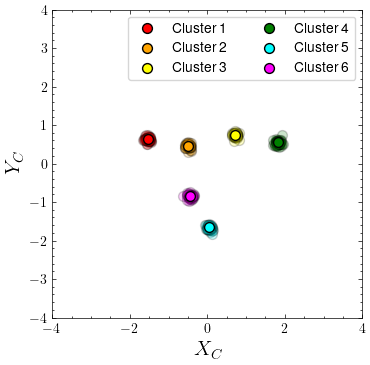

In [104]:
# Number of clusters and points per cluster
num_clusters = 6
num_points = 50

# Colors for the clusters
colors = ['red','orange','yellow','green','cyan','magenta']

# Randomly generate cluster centers within a specified range
np.random.seed(110)  # For reproducibility
centers = np.random.uniform(-2, 2, size=(num_clusters, 2))

# Standard deviation for tighter clusters
std_dev = 0.05

# Plotting
plt.figure(figsize=(4, 4))

# Plot Gaussian-distributed points for each color cluster
for i, (center, color) in enumerate(zip(centers, colors)):
    points = np.random.normal(loc=center, scale=std_dev, size=(num_points, 2))
    plt.scatter(points[:, 0], points[:, 1], color=color, edgecolor='black', alpha=0.2, s=50)

# Add a single opaque point for each cluster for the legend
for i, (center, color) in enumerate(zip(centers, colors)):
    plt.scatter(center[0], center[1], color=color, edgecolor='black', alpha=1, s=50, label=f'Cluster {i + 1}')

# Configure legend with two columns and frame
plt.legend(loc='upper right', ncol=2, frameon=True)
plt.xlabel('$X_{C}$',fontsize=15)
plt.ylabel('$Y_{C}$',fontsize=15)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.title('')
plt.show()


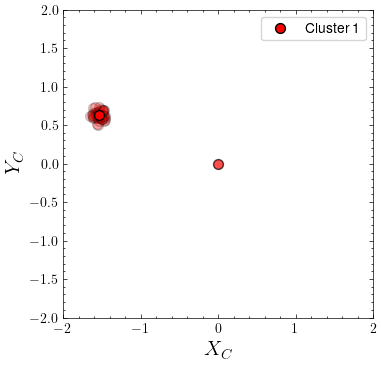

In [5]:
# Number of clusters and points per cluster
num_clusters = 1
num_points = 50

# Colors for the clusters
colors = ['red','orange','yellow','green','cyan','magenta']

# Randomly generate cluster centers within a specified range
np.random.seed(110)  # For reproducibility
centers = np.random.uniform(-2, 2, size=(num_clusters, 2))

# Standard deviation for tighter clusters
std_dev = 0.05

# Plotting
plt.figure(figsize=(4, 4))

# Plot Gaussian-distributed points for each color cluster
for i, (center, color) in enumerate(zip(centers, colors)):
    points = np.random.normal(loc=center, scale=std_dev, size=(num_points, 2))
    plt.scatter(points[:, 0], points[:, 1], color=color, edgecolor='black', alpha=0.2, s=50)
    plt.scatter([0],[0],color=color,edgecolor='black',alpha=0.7,s=50)
# Add a single opaque point for each cluster for the legend
for i, (center, color) in enumerate(zip(centers, colors)):
    plt.scatter(center[0], center[1], color=color, edgecolor='black', alpha=1, s=50, label=f'Cluster {i + 1}')

# Configure legend with two columns and frame
plt.legend(loc='upper right', ncol=2, frameon=True)
plt.xlabel('$X_{C}$',fontsize=15)
plt.ylabel('$Y_{C}$',fontsize=15)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('')
plt.show()


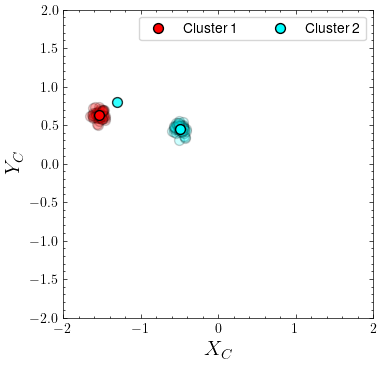

In [13]:
# Number of clusters and points per cluster
num_clusters = 2
num_points = 50

# Colors for the clusters
colors = ['red','cyan','magenta']

# Randomly generate cluster centers within a specified range
np.random.seed(110)  # For reproducibility
centers = np.random.uniform(-2, 2, size=(num_clusters, 2))

# Standard deviation for tighter clusters
std_dev = 0.05

# Plotting
plt.figure(figsize=(4, 4))

# Plot Gaussian-distributed points for each color cluster
for i, (center, color) in enumerate(zip(centers, colors)):
    points = np.random.normal(loc=center, scale=std_dev, size=(num_points, 2))
    plt.scatter(points[:, 0], points[:, 1], color=color, edgecolor='black', alpha=0.2, s=50)
plt.scatter([-1.3],[0.8],color=color,edgecolor='black',alpha=0.8,s=50)
# Add a single opaque point for each cluster for the legend
for i, (center, color) in enumerate(zip(centers, colors)):
    plt.scatter(center[0], center[1], color=color, edgecolor='black', alpha=1, s=50, label=f'Cluster {i + 1}')

# Configure legend with two columns and frame
plt.legend(loc='upper right', ncol=2, frameon=True)
plt.xlabel('$X_{C}$',fontsize=15)
plt.ylabel('$Y_{C}$',fontsize=15)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('')
plt.show()


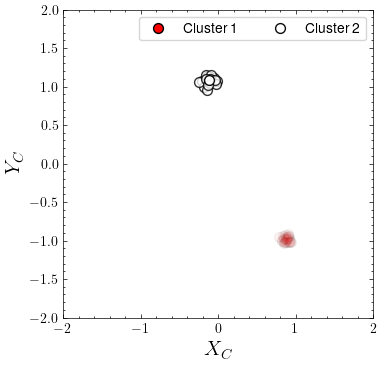

In [35]:
# Number of clusters and points per cluster
num_clusters = 2
num_points = 25

# Colors for the clusters
colors = ['red','white','magenta']

# Randomly generate cluster centers within a specified range
np.random.seed(1120)  # For reproducibility
centers = np.random.uniform(-2, 2, size=(num_clusters, 2))

# Standard deviation for tighter clusters
std_dev = 0.05

# Plotting
plt.figure(figsize=(4, 4))

# Plot Gaussian-distributed points for each color cluster
for i, (center, color) in enumerate(zip(centers, colors)):
    points = np.random.normal(loc=center, scale=std_dev, size=(num_points, 2))
    plt.scatter(points[:, 0], points[:, 1], color=color, edgecolor='black', alpha=0.05 if color!='white' else 0.8, s=50)
    
# Add a single opaque point for each cluster for the legend
plt.scatter([-100],[-100],color=colors[0],edgecolor='black',alpha=1,s=50, label=f'Cluster 1')
for i, (center, color) in enumerate(zip(centers, colors)):
    if color == "white":
        plt.scatter(center[0], center[1], color=color, edgecolor='black', alpha=0.95, s=50, label=f'Cluster {i + 1}')
    else:
        plt.scatter(center[0], center[1], color=color, edgecolor='black', alpha=0.05, s=50)

# Configure legend with two columns and frame
plt.legend(loc='upper right', ncol=2, frameon=True)
plt.xlabel('$X_{C}$',fontsize=15)
plt.ylabel('$Y_{C}$',fontsize=15)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('')
plt.show()
